<a href="https://colab.research.google.com/github/raz0208/Agritech-Pest-Prediction/blob/main/Agritech_Pest_Prediction_SARIMA_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis For Agritech Pest Prediction

### **SARIMA** Model Implementation:

In [1]:
# # Uninstall potentially conflicting versions first
# !pip uninstall -y pmdarima numpy

# # Install the latest NumPy 1.x version (e.g., 1.26.4)
# !pip install numpy==1.26.4

# # Now install pmdarima (hopefully it links against NumPy 1.26.4)
# # Use --no-cache-dir just to be safe
# !pip install --no-cache-dir pmdarima==2.0.4

In [2]:
# import required libaraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [3]:
# Load datasets
Merged_Dataset_df = pd.read_csv('/content/Final_Merged_Dataset_Cleaned.csv')

In [4]:
# Display basic info for  datasets Final_Merged_Dataset_Cleaned
print(Merged_Dataset_df.head(), '\n')
print(Merged_Dataset_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  Day Avg_temp  \
0                13.91      13.6       14.4             97.65         22.34   
1                20.78      20.1       21.2             83.49         23.52   
2                19.03      18.7       19.5             96.87         25.67   
3                15.33      15.0       15.7             82.29         25.87   
4                15.48      15.0       16.0             87.12         26.41   

   Day Min_temp  Day Max_temp  Day Avg_Humidity  Temp_change  

In [5]:
# Convert 'Date' column to datetime format
Merged_Dataset_df['Date'] = pd.to_datetime(Merged_Dataset_df['Date'])

# Set Date column as index
Merged_Dataset_df.set_index('Date', inplace=True)

In [6]:
# Drop redundant columns for time series modeling
DateAgg_df = Merged_Dataset_df[['Number of Insects']].copy()

# Resample data by date (sum over locations for the same day)
DateAgg_df = DateAgg_df.resample('D').sum()

# Show the processed daily data
print(DateAgg_df.head(10))

            Number of Insects
Date                         
2024-07-05                0.0
2024-07-06                0.0
2024-07-07                0.0
2024-07-08                0.0
2024-07-09                0.0
2024-07-10                0.0
2024-07-11                0.0
2024-07-12                0.0
2024-07-13                0.0
2024-07-14                1.0


### Visualization trends

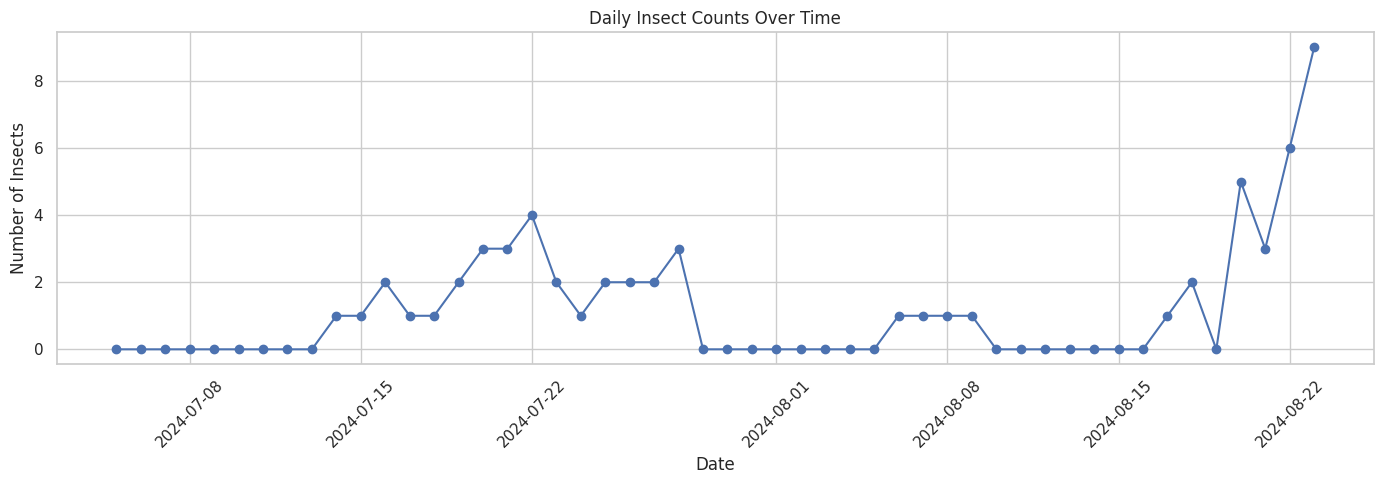

In [7]:
##-- ### Visualization trends ### --##

# Set plot style
sns.set(style="whitegrid")

# Plot the time series
plt.figure(figsize=(14, 5))
plt.plot(DateAgg_df.index, DateAgg_df['Number of Insects'], marker='o', linestyle='-')
plt.title('Daily Insect Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

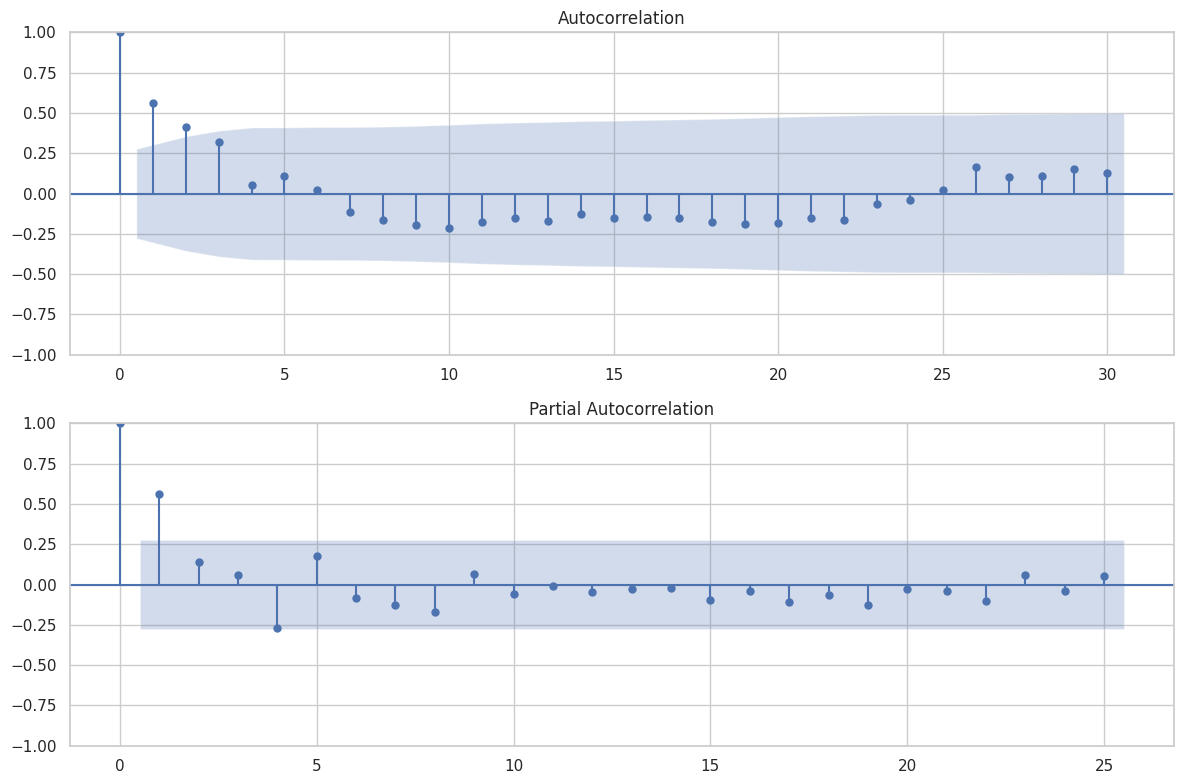

In [8]:
# Plot ACF and PACF to examine autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(DateAgg_df['Number of Insects'], lags=30, ax=ax[0])
plot_pacf(DateAgg_df['Number of Insects'], lags=25, ax=ax[1])
plt.tight_layout()
plt.show()

### Check for Stationarity (ADF Test)

ADF Statistic: -1.7530607202128317
p-value: 0.4040019312158851
# Lags Used: 7
# Observations: 42
Critical Values:
   1%: -3.596635636000432
   5%: -2.933297331821618
   10%: -2.6049909750566895
⚠️ Series is not stationary (p >= 0.05) 



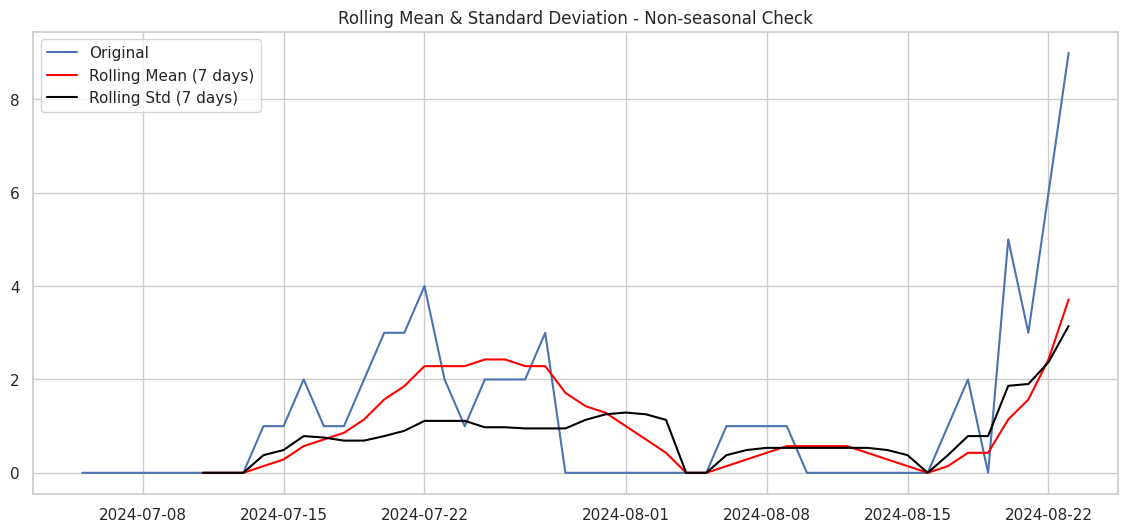

In [9]:
# Perform Augmented Dickey-Fuller (ADF) test to check for stationarity
def check_stationarity(series):
    adf_result = adfuller(series.dropna())

    result = {
        "ADF Statistic": adf_result[0],
        "p-value": adf_result[1],
        "# Lags Used": adf_result[2],
        "# Observations": adf_result[3],
        "Critical Values": adf_result[4]
    }

    # Interpretation
    result["Stationary"] = adf_result[1] < 0.05

    print("ADF Statistic:", result["ADF Statistic"])
    print("p-value:", result["p-value"])
    print("# Lags Used:", result["# Lags Used"])
    print("# Observations:", result["# Observations"])
    print("Critical Values:")
    for key, value in result["Critical Values"].items():
        print(f"   {key}: {value}")

    if result["Stationary"]:
        print("✅ Series is stationary (p < 0.05)")
    else:
        print("⚠️ Series is not stationary (p >= 0.05)", "\n")

    # Plot rolling mean and std
    rolling_mean = series.rolling(window=7).mean()
    rolling_std = series.rolling(window=7).std()

    plt.figure(figsize=(14,6))
    plt.plot(series, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean (7 days)', color='red')
    plt.plot(rolling_std, label='Rolling Std (7 days)', color='black')
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation - Non-seasonal Check")
    plt.show()

    #return result

check_stationarity(DateAgg_df['Number of Insects'])

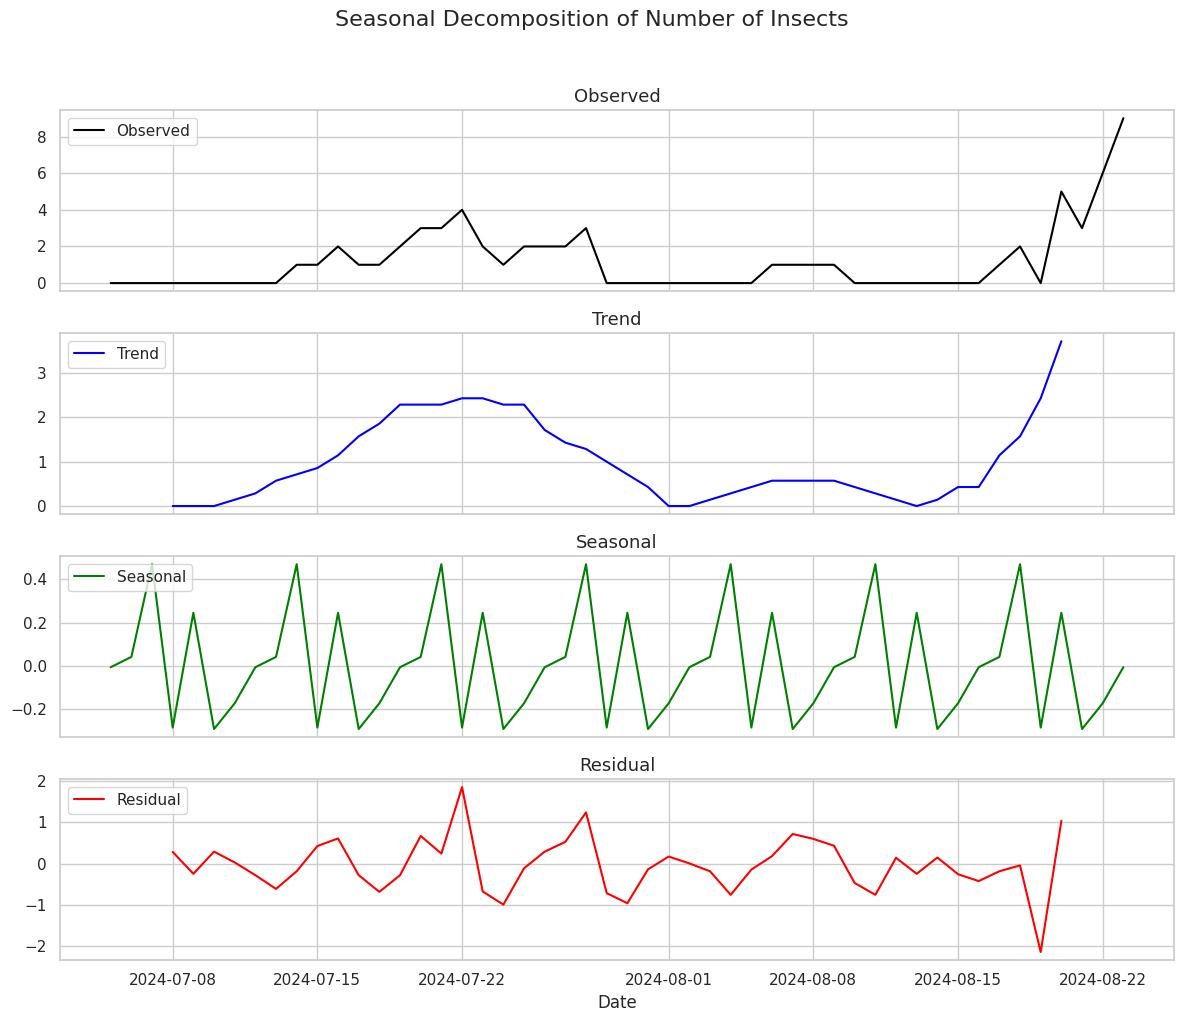

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

insects_series = DateAgg_df['Number of Insects']

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Seasonal decomposition
decomposition = seasonal_decompose(insects_series, model='additive', period=7)  # Weekly seasonality

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot original series
axs[0].plot(insects_series, label='Observed', color='black')
axs[0].set_title('Observed', fontsize=13)
axs[0].legend(loc='upper left')

# Plot trend
axs[1].plot(trend, label='Trend', color='blue')
axs[1].set_title('Trend', fontsize=13)
axs[1].legend(loc='upper left')

# Plot seasonal
axs[2].plot(seasonal, label='Seasonal', color='green')
axs[2].set_title('Seasonal', fontsize=13)
axs[2].legend(loc='upper left')

# Plot residual
axs[3].plot(residual, label='Residual', color='red')
axs[3].set_title('Residual', fontsize=13)
axs[3].legend(loc='upper left')

# General layout adjustments
plt.suptitle("Seasonal Decomposition of Number of Insects", fontsize=16, y=1.02)
plt.xlabel("Date", fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

### Split train and test set

In [15]:
# Ensure datetime index if not already
DateAgg_df.index = pd.to_datetime(DateAgg_df.index)

# Define train-test split point (e.g., 90% train)
split_ratio = 0.9
split_point = int(len(DateAgg_df) * split_ratio)

# Split the data
DateAgg_train = DateAgg_df.iloc[:split_point]['Number of Insects']
DateAgg_test = DateAgg_df.iloc[split_point:]['Number of Insects']

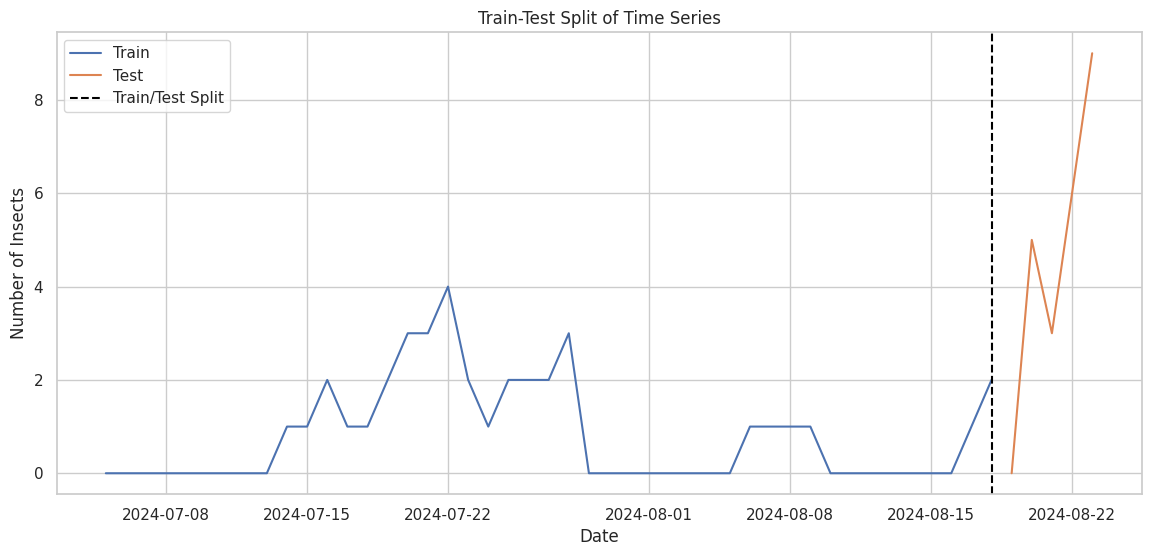

In [16]:
# Optional: visualize the split
plt.figure(figsize=(14, 6))
plt.plot(DateAgg_train, label='Train')
plt.plot(DateAgg_test, label='Test')
plt.axvline(DateAgg_train.index[-1], color='black', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('Train-Test Split of Time Series')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.show()

### Fit the SARIMA model

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Fit SARIMA model
model = auto_arima(
    DateAgg_train,
    seasonal=True,
    m=7,
    d=None,
    D=1,
    start_p=0, max_p=3,   # Range of p values
    start_q=0, max_q=3,   # Range of q values
    start_P=0, max_P=2,   # Seasonal AR order
    start_Q=0, max_Q=2,   # Seasonal MA order
    stepwise=True,
    enforce_stationarity=False,
    enforce_invertibility=False,
    suppress_warnings=True,
    trace=True,           # Print the search process
    error_action='ignore'
)

# Summary of the best model
print(model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=144.925, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=117.182, Time=0.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=143.024, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=125.508, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=111.066, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=137.802, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=113.019, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=113.001, Time=0.22 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=124.061, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=114.847, Time=0.60 sec
 ARIMA(1,0,0)(2,1,0)[7]             : AIC=109.068, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[7]             : AIC=115.380, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[7]             : AIC=inf, Time=0.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[7]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(2,1,0)[7]             : AIC=136.850, Time=0.06 sec
 ARIMA(2,0,0)(2,1,0)[7]             : AIC=111.019, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,0)[7]             : AIC=111.001, Time=0.15 sec
 ARIMA(0,0,1)(2,1,0)[7]             : AIC=122.367, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[7]             : AIC=112.849, Time=0.39 sec

Best model:  ARIMA(1,0,0)(2,1,0)[7]          
Total fit time: 5.822 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   45
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 7)   Log Likelihood                 -50.534
Date:                           Wed, 09 Apr 2025   AIC                            109.068
Time:                                   15:19:58   BIC                            115.619
Sample:                               07-05-2024   HQIC                           111.399
                                    - 08-18-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

### Forcast by SARIMA model

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


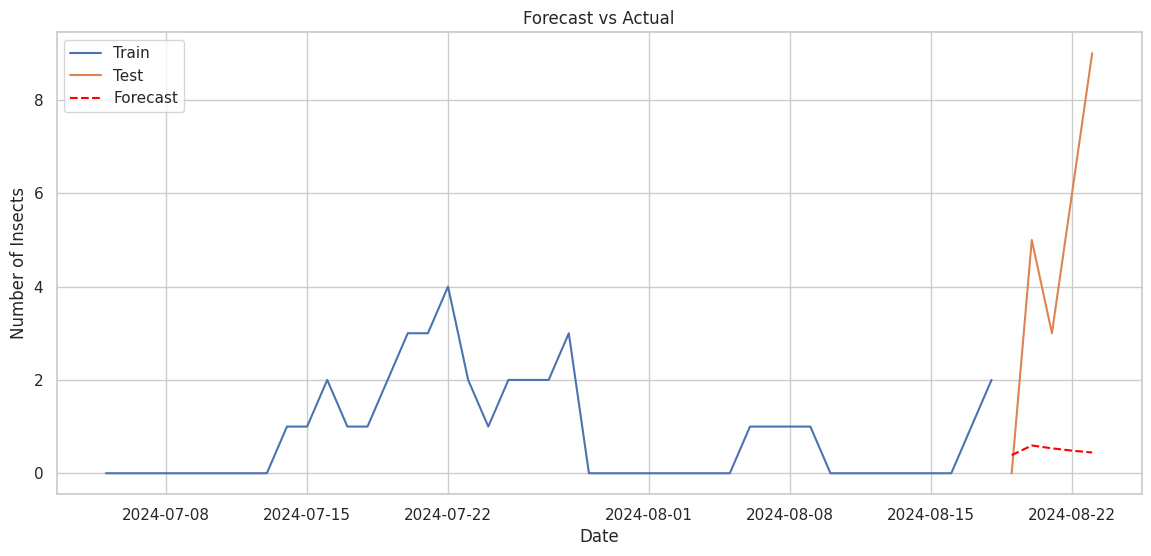

In [32]:
# Step 2: Forecast for the test period
forecast = model.predict(n_periods=len(DateAgg_test))
forecast = pd.Series(forecast, index=DateAgg_test.index)


# Step 3: Plot forecast vs actual for train and test
plt.figure(figsize=(14, 6))
plt.plot(DateAgg_train.index, DateAgg_train, label='Train')
plt.plot(DateAgg_test.index, DateAgg_test, label='Test')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--', color='red')
plt.legend()
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.show()

### Apply differencing (if needed) and check Stationarity for non_seasonal data

In [40]:
series = DateAgg_df['Number of Insects']

# Function
def handle_nonseasonal_stationarity(series, max_diff=6, verbose=True):
    diff_series = series.copy()
    d = 0

    for i in range(max_diff + 1):
        result = adfuller(diff_series.dropna())
        p_value = result[1]
        if verbose:
            print(f"Non-seasonal differencing d={d}, ADF p-value: {p_value:.4f}")
        if p_value < 0.05:
            if verbose:
                print(f"✅ Stationary after {d} non-seasonal difference(s)\n")
            return diff_series, d
        diff_series = diff_series.diff()
        d += 1

    print(f"⚠️ Series may not be stationary after {max_diff} non-seasonal differences.\n")
    return diff_series, d

### Apply differencing (if needed) and check stationarity for seasonal data

In [41]:
def handle_seasonal_stationarity(series, seasonal_period=7, max_diff=6, verbose=True):
    diff_series = series.copy()
    D = 0

    for i in range(max_diff + 1):
        result = adfuller(diff_series.dropna())
        p_value = result[1]
        if verbose:
            print(f"Seasonal differencing D={D}, ADF p-value: {p_value:.4f}")
        if p_value < 0.05:
            if verbose:
                print(f"✅ Stationary after {D} seasonal difference(s)\n")
            return diff_series, D
        diff_series = diff_series.diff(seasonal_period)
        D += 1

    print(f"⚠️ Series may not be seasonally stationary after {max_diff} seasonal differences.\n")
    return diff_series, D

In [42]:
series = DateAgg_df['Number of Insects']

# First handle seasonal stationarity (D)
seasonally_diffed, D = handle_seasonal_stationarity(series, seasonal_period=7)

# Then handle non-seasonal stationarity (d)
final_stationary_series, d = handle_nonseasonal_stationarity(seasonally_diffed)

print(f"Final differencing parameters: d = {d}, D = {D}")

Seasonal differencing D=0, ADF p-value: 0.4040
Seasonal differencing D=1, ADF p-value: 0.9561
Seasonal differencing D=2, ADF p-value: 0.9766
Seasonal differencing D=3, ADF p-value: 0.0039
✅ Stationary after 3 seasonal difference(s)

Non-seasonal differencing d=0, ADF p-value: 0.0039
✅ Stationary after 0 non-seasonal difference(s)

Final differencing parameters: d = 0, D = 3


In [67]:
# Use the same train-test split
# Define train-test split point (e.g., 90% train)
split_ratio = 0.9
split_point = int(len(DateAgg_df) * split_ratio)

DateAgg_train = DateAgg_df.iloc[:split_point]['Number of Insects']
DateAgg_test = DateAgg_df.iloc[split_point:]['Number of Insects']

# Fit SARIMA model (using SARIMAX with no exogenous variables)
sarima_model = SARIMAX(
    DateAgg_train,
    order=(1, 0, 0),               # (p, d, q) — you can tune p & q manually or use prior auto_arima result
    seasonal_order=(2, 3, 0, 7),   # (P, D, Q, m) — m=7 for weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                 Number of Insects   No. Observations:                   45
Model:             SARIMAX(1, 0, 0)x(2, 3, 0, 7)   Log Likelihood                 -16.679
Date:                           Wed, 09 Apr 2025   AIC                             41.358
Time:                                   16:14:30   BIC                             42.147
Sample:                               07-05-2024   HQIC                            39.656
                                    - 08-18-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1473      0.688      1.667      0.096      -0.202       2.496
ar.S.L7       -1.2155      0.483     -2.518

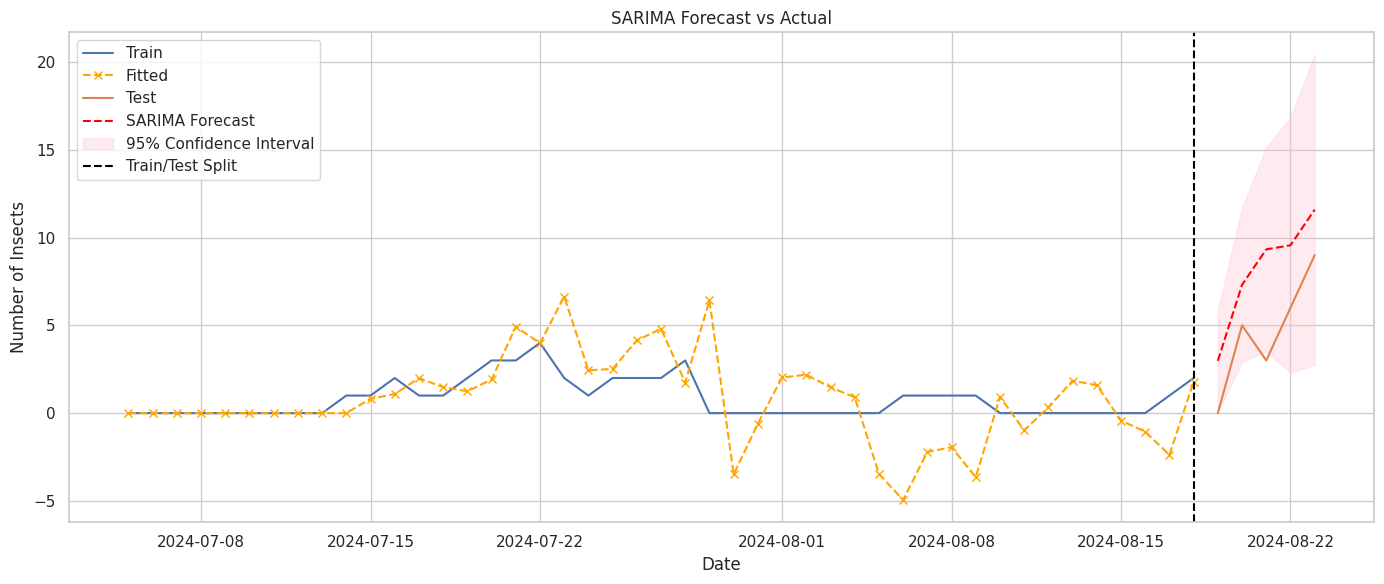

In [68]:
# Forecast for the test period
sarima_forecast = sarima_result.get_forecast(steps=len(DateAgg_test))
forecast_mean = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(DateAgg_train.index, DateAgg_train, label='Train')
plt.plot(DateAgg_train.index, sarima_result.fittedvalues, label='Fitted', marker='x', linestyle='--', color='orange')
plt.plot(DateAgg_test.index, DateAgg_test, label='Test')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.axvline(DateAgg_train.index[-1], color='black', linestyle='--', label='Train/Test Split')
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Number of Insects")
plt.legend()
plt.tight_layout()
plt.show()

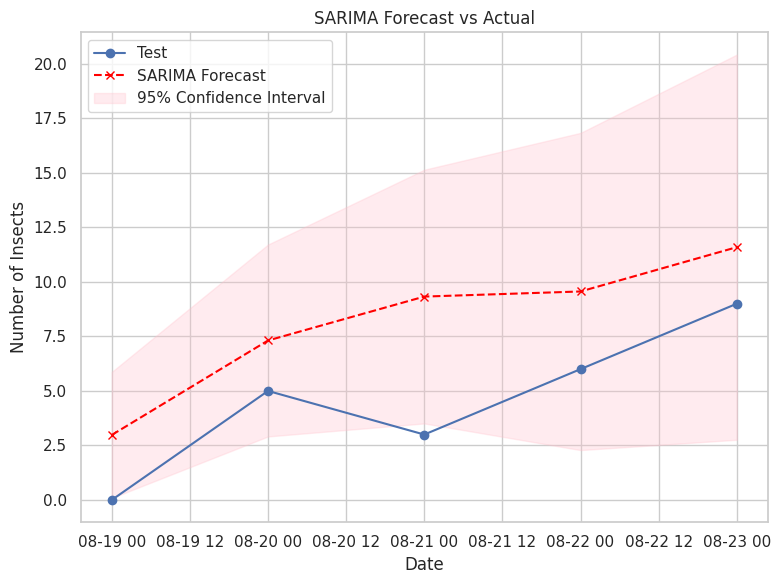

In [69]:
# Plot forecast vs actual
plt.figure(figsize=(8, 6))
plt.plot(DateAgg_test.index, DateAgg_test, label='Test', marker='o')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMA Forecast', color='red', linestyle='--', marker='x')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Number of Insects")
plt.legend()
plt.tight_layout()
plt.show()